# Validation with SHACL

<a href="https://githubtocolab.com/gleanerio/archetype/blob/master/networks/commons/validationSHACL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.png" alt="Open in Colab"/></a>



## Requirements

In [ ]:
!pip install -q rdflib
!pip install -q shapely
!pip install -q pyld
!pip install -q kglab
!pip install -q minio
!pip install -q pyshacl
!pip install -q tqdm

## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning
import kglab
from minio import Minio
from rdflib import Graph, plugin
import plotly.express as px
import pandas as pd
from urllib.request import urlopen
import os
from tqdm import tqdm


## Supporting functions

In [2]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def popper(input):
    lines = input.decode().split('\n') # Split input into separate lines
    modified_lines = []

    for line in lines:
        newline = line.replace("http://schema.org", "https://schema.org")
        segments = newline.split(' ')

        if len(segments) > 3:
            segments.pop()   # Remove the last two segment
            segments.pop()
            new_line = ' '.join(segments) + ' .'
            modified_lines.append(new_line)

    result_string = '\n'.join(modified_lines)

    return(result_string)

def publicurls(client, bucket, prefix):
    urls = []
    objects = client.list_objects(bucket, prefix=prefix, recursive=True)
    for obj in objects:
        result = client.stat_object(bucket, obj.object_name)

        if result.size > 0:  #  how to tell if an objet   obj.is_public  ?????
            url = client.presigned_get_object(bucket, obj.object_name)
            # print(f"Public URL for object: {url}")
            urls.append(url)

    return urls


## Object store files

In [3]:
# OIH testing graphs
client = Minio("ossapi.oceaninfohub.org:80",  secure=False) # Create client with anonymous access.
urls = publicurls(client, "public", "graph")
for u in urls:
  print(u)
  
  
# Local S3 server  

http://ossapi.oceaninfohub.org/public/graphs/summonedafricaioc_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedaquadocs_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonededmerp_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonededmo_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedemodnet_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinanodc_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemardocuments_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarexperts_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarinstitutions_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemartraining_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarvessels_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedmarinet

## Load

Load and align the schema.org context

In [5]:
# set the Data Graph URL to what you want to validate
dgurl = "http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq"
# df = urlopen(dgurl)
dg = urlopen(dgurl).read()
rp = popper(dg)

# Alternately, load from local disk
# with open('./localRDF.nq', 'rb') as file:
#     dg = file.read()
# rp = popper(dg)

In [6]:
namespaces = {
    "sh":   "http://www.w3.org/ns/shacl#" ,
    "schema": "https://schema.org/"
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

try:
    g = Graph().parse(data=rp, format='nt')
    r = g.serialize(format='nt')
    kg.load_rdf_text(r)
except Exception as e:
    print("Exception: {}\n --".format(str(e)))
    raise e

print("Graph loaded with {} triples".format(len(g)))

Graph loaded with 145779 triples


## SPARQL Counts

Do a simple count query to see what we have in our graph and also just to verify we all good to this point

In [7]:
# For the radar plot later we will need to know the number of resources in the
# graph that we will be checking.  We should break down the types too.
# It might be a case where we do some radar plots only for given types.

counts = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>


SELECT (COUNT(?type) as ?count) ?type
WHERE {
        ?s rdf:type ?type
        FILTER (?type IN
                (schema:ResearchProject, schema:Project, schema:Organization, schema:Dataset,
                    schema:CreativeWork, schema:Person, schema:Map, schema:Course,
                    schema:CourseInstance, schema:Event, schema:Vehicle)
        )
}
GROUP BY ?type
ORDER BY DESC(?count)
"""

countsdf = kg.query_as_df(counts)
countsdf.head()
# countsdf["count"].sum()

,count,type
0,2141,schema:Organization
1,2015,schema:Dataset
2,1372,schema:Person


## Shapes Section

* Basic shape: (name, description)
* connections shape: (url, Dataset:distribution)
* id shape: dataset:identifier
* licensing
* geo shape:  dataset:geo  course:geo
* temporal shape: dataset, shape
* funding
* citation
* For GDPR (sp) look for type Person and identifier

Could the shape help to identifie SG14 or EOV data.  Perharps this isn't a thing that SHACL can hep with?  wHAT is needed to much sucn resource alignment work/exist.

How might this relate to the Match Making topic PLB spoke about.



In [8]:
basicShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .

oihval:IDShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:CreativeWork, schema:ResearchProject, schema:Person, schema:Course, schema:Organization, schema:Dataset, schema:Map, schema:Vehicle ;
    shacl:message "Graph requires ID"@en ;
    shacl:description "URL OIH shape guidance" ;
    shacl:nodeKind shacl:IRI ;
    .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:CreativeWork, schema:ResearchProject, schema:Person, schema:Course, schema:Organization, schema:Dataset, schema:Map, schema:Vehicle ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:nameResourceProperty,
        oihval:descriptionResourceProperty ;
    .

oihval:nameResourceProperty
    a shacl:PropertyShape ;
    shacl:path schema:name ;
    shacl:nodeKind shacl:Literal ;
    shacl:minCount 1 ;
    shacl:severity shacl:Warning ;
    shacl:message "Name is suggested "@en ;
    shacl:description "https://foo.org" ;
    .

oihval:descriptionResourceProperty
    a shacl:PropertyShape ;
    shacl:path schema:description;
    shacl:nodeKind shacl:Literal ;
    shacl:minCount 1 ;
    shacl:message "Description missing"@en ;
    shacl:description "https://book.oceaninfohub.org/foundation/foundation.html#other-properties" ;
    .
"""


In [9]:
connectionShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:CreativeWork, schema:ResearchProject, schema:Person, schema:Course, schema:Organization, schema:Dataset, schema:Map, schema:Vehicle ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:urlResourceProperty;
    .


oihval:urlResourceProperty
    a shacl:PropertyShape ;
    shacl:path schema:url ;
    shacl:maxCount 1 ;
    shacl:minCount 1 ;
    shacl:nodeKind shacl:IRIOrLiteral ;
    shacl:message "URL missing"@en ;
    shacl:description "https://foo.org" ;
    .


"""


In [10]:
licenseShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:Dataset ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:urlResourceProperty;
    .


oihval:urlResourceProperty
    a shacl:PropertyShape ;
    shacl:path schema:license ;
    shacl:maxCount 1 ;
    shacl:minCount 1 ;
    shacl:message "license missing"@en ;
    shacl:description "https://foo.org" ;
    .


"""

In [11]:
identifierShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:CreativeWork, schema:ResearchProject, schema:Person, schema:Course, schema:Organization, schema:Dataset, schema:Map, schema:Vehicle ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:urlIdentifierProperty;
    .


oihval:urlIdentifierProperty
    a shacl:PropertyShape ;
    shacl:path schema:identifier ;
    shacl:maxCount 1 ;
    shacl:minCount 1 ;
    shacl:nodeKind shacl:IRIOrLiteral ;
    shacl:message "Identifier missing"@en ;
    shacl:description "https://foo.org" ;
    .


"""

In [12]:
personIDShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:Person ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:urlIdentifierProperty;
    .


oihval:urlIdentifierProperty
    a shacl:PropertyShape ;
    shacl:path schema:identifier ;
    shacl:maxCount 1 ;
    shacl:minCount 1 ;
    shacl:nodeKind shacl:IRIOrLiteral ;
    shacl:message "Identifier missing"@en ;
    shacl:description "https://foo.org" ;
    .


"""

In [13]:
geoShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:Dataset ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:geoProperty ;
    .


oihval:geoProperty
    a shacl:PropertyShape ;
    shacl:path schema:spatialCoverage ;
    shacl:maxCount 1 ;
    shacl:minCount 1 ;
    shacl:message "spatialCoverage missing"@en ;
    shacl:description "https://foo.org" ;
    .


"""

In [14]:
geoPolygon = R"""
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:GeoShape ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:polygonStringProperty,
        oihval:polygonCloseProperty ;
    .

oihval:polygonStringProperty
    a shacl:PropertyShape ;
    shacl:path schema:polygon  ;
    shacl:message "The string must consists of numeric, space-separated items."@en ;
    shacl:maxCount 1 ;
    shacl:description "https://foo.org" ;
    shacl:pattern "^(?:\\d+\\s+)*\\d+$" ;    .


oihval:polygonCloseProperty
    a shacl:PropertyShape ;
    shacl:path schema:polygon ;
    shacl:message "The polygon string must have the first and last items are the same"@en ;
    shacl:maxCount 1 ;
    shacl:description "https://foo.org" ;
	  shacl:pattern "^(\\d+)\\s+(\\d+)(?:\\s+\\d+)+\\s+\\1$" ;
    .
"""

In [15]:
# force check the presence of WKT

geoSPARQL = R"""
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix geosparql: <http://www.opengis.net/ont/geosparql#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:Dataset ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:pointProperty ;
    .

oihval:pointProperty
    a geosparql:hasGeometry ;
    shacl:path geosparql:asWKT  ;
    shacl:message "geoSPARQL POINT needs a WKT entry"@en ;
    shacl:maxCount 1 ;
    shacl:description "https://foo.org" ; .



"""

In [16]:
distributionShape = """
@prefix schema: <https://schema.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix shacl: <http://www.w3.org/ns/shacl#> .
@prefix oihval: <https://oceans.collaborium.io/voc/validation/1.0.1/shacl#> .

oihval:DatasetCommonShape
    a shacl:NodeShape ;
    shacl:targetClass  schema:Dataset ;
    shacl:message "OIH Resource to Query validation" ;
    shacl:description "OIH shape guidance" ;
    shacl:property
        oihval:urlResourceProperty;
    .


oihval:urlResourceProperty
    a shacl:PropertyShape ;
    shacl:path schema:distribution ;
    shacl:maxCount 3 ;
    shacl:minCount 3 ;
    shacl:nodeKind shacl:IRIOrLiteral ;
    shacl:severity shacl:Warning ;
    shacl:message "URL missing"@en ;
    shacl:description "https://foo.org" ;
    .


"""

In [17]:

sparql = """
PREFIX shacl: <http://www.w3.org/ns/shacl#>

SELECT  ?severity  ?constraint ?path ?message (STR(?focus) AS ?focusURL) ?focusType ?path ?value
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
     OPTIONAL {
    ?focus rdf:type ?focusType .
   }
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
     OPTIONAL {
    ?id shacl:sourceConstraintComponent ?constraint .
    }
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""





## Loop over all Frames

In [20]:
df = pd.DataFrame(columns=["severity", "constraint", "path", "message", "focusURL", "shape"])
m = {"geoPolygon": geoPolygon, "geoShape": geoShape, "basicShape": basicShape, "connectionShape": connectionShape, "identifierShape": identifierShape, "personIDShape": personIDShape, "licenseShape": licenseShape, "distributionShape": distributionShape}
# m = {"distributionShape": distributionShape}

# m = { "geoPolygon": geoPolygon}

dfs_to_concat = []  # Create an empty list to store DataFrames

for key, value in tqdm(m.items()):
  conforms, report_graph, report_text = kg.validate(
    shacl_graph=value,
    shacl_graph_format="ttl")
  # print(report_text)
  dfr = report_graph.query_as_df(sparql)
  dfr['shape'] = key
  dfs_to_concat.append(dfr)  # Append the current_df to the list

df = pd.concat(dfs_to_concat, ignore_index=True)



100%|██████████| 8/8 [00:19<00:00,  2.48s/it]


In [21]:
df.head(10)

,severity,constraint,path,message,focusURL,value,shape
0,sh:Violation,sh:PatternConstraintComponent,schema:polygon,The polygon string must have the first and las...,https://gleaner.io/xid/genid/cggj3d3k59mc73f1k8jg,"{'type': 'Point', 'coordinates': [-127.9697, 5...",geoPolygon
1,sh:Violation,sh:PatternConstraintComponent,schema:polygon,The polygon string must have the first and las...,https://gleaner.io/xid/genid/cggj4f3k59mc73f1pjc0,"{'type': 'Polygon', 'coordinates': [[[-128.057...",geoPolygon
2,sh:Violation,sh:PatternConstraintComponent,schema:polygon,"The string must consists of numeric, space-sep...",https://gleaner.io/xid/genid/cggj3fjk59mc73f1kkug,"{'type': 'Polygon', 'coordinates': [[[-63.9925...",geoPolygon
3,sh:Violation,sh:PatternConstraintComponent,schema:polygon,"The string must consists of numeric, space-sep...",https://gleaner.io/xid/genid/cggj3trk59mc73f1mr9g,"{'type': 'Point', 'coordinates': [-124.769333,...",geoPolygon
4,sh:Violation,sh:PatternConstraintComponent,schema:polygon,The polygon string must have the first and las...,https://gleaner.io/xid/genid/cggj4jbk59mc73f1q960,"{'type': 'Polygon', 'coordinates': [[[-55.2413...",geoPolygon
5,sh:Violation,sh:PatternConstraintComponent,schema:polygon,The polygon string must have the first and las...,https://gleaner.io/xid/genid/cggj3drk59mc73f1kc60,"{'type': 'Polygon', 'coordinates': [[[-125.223...",geoPolygon
6,sh:Violation,sh:PatternConstraintComponent,schema:polygon,"The string must consists of numeric, space-sep...",https://gleaner.io/xid/genid/cggj4a3k59mc73f1oppg,"{'type': 'Polygon', 'coordinates': [[[-66.2641...",geoPolygon
7,sh:Violation,sh:PatternConstraintComponent,schema:polygon,The polygon string must have the first and las...,https://gleaner.io/xid/genid/cggj4ajk59mc73f1oscg,"{'type': 'Polygon', 'coordinates': [[[-55.3782...",geoPolygon
8,sh:Violation,sh:PatternConstraintComponent,schema:polygon,"The string must consists of numeric, space-sep...",https://gleaner.io/xid/genid/cggj47jk59mc73f1ocu0,"{'type': 'Point', 'coordinates': [-126.847847,...",geoPolygon
9,sh:Violation,sh:PatternConstraintComponent,schema:polygon,The polygon string must have the first and las...,https://gleaner.io/xid/genid/cggj433k59mc73f1njq0,"{'type': 'Point', 'coordinates': [-129.0823133...",geoPolygon


In [22]:
summary = df.groupby([df["shape"]]).count()
summary.reset_index(level=0, inplace=True)
summary['valid'] = summary['severity'].apply(lambda x: (countsdf["count"].sum()) - x)

In [23]:
summary.head(20)

,shape,severity,constraint,path,message,focusURL,value,valid
0,basicShape,3513,3513,3513,3513,3513,0,2015
1,connectionShape,3510,3510,3510,3510,3510,0,2018
2,distributionShape,1855,1855,1855,1855,1855,0,3673
3,geoPolygon,4076,4076,4076,4076,4076,4076,1452
4,geoShape,523,523,523,523,523,0,5005
5,identifierShape,4878,4878,4878,4878,4878,0,650
6,personIDShape,1372,1372,1372,1372,1372,0,4156


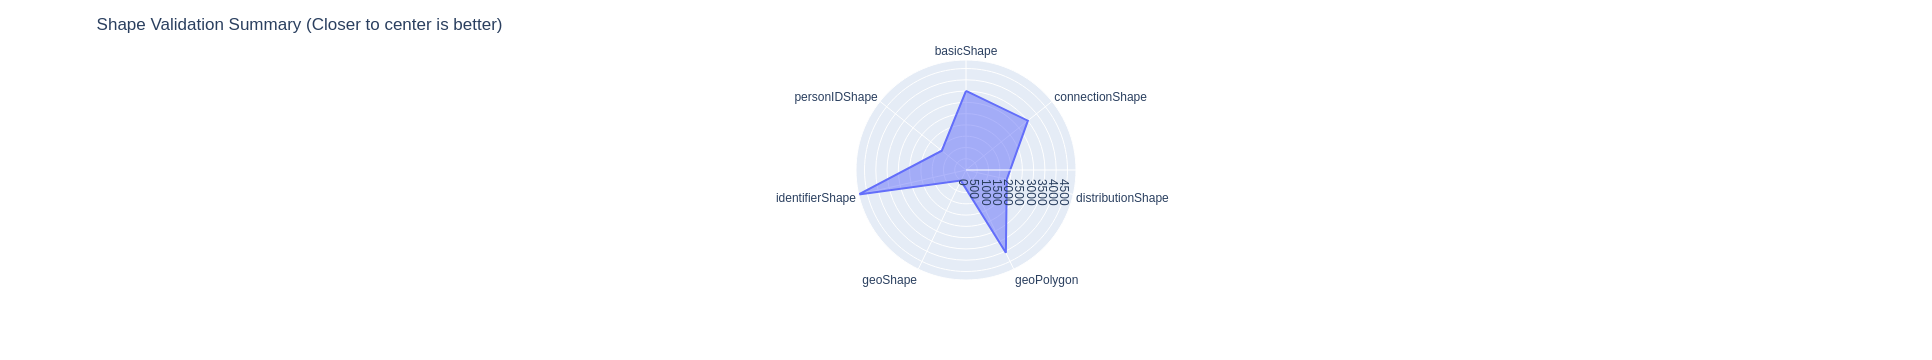

In [27]:
dfr = pd.DataFrame(dict(
    r=summary['severity'].tolist(),   # vs valid which is hard since num resources can be < errors (multiple errors in a resource)
    theta=summary['shape'].tolist()))
fig = px.line_polar(dfr, r='r', theta='theta',line_close=True)
fig.update_traces(fill='toself')

# fig.add_trace( name="Validation Summary" )

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, summary["severity"].max()]
      # range=[0, countsdf["count"].sum()]
    )),
  showlegend=True,
  title="Shape Validation Summary (Closer to center is better)"
)

fig.show()

In [28]:
# Save to CSV and analyze with tools like OpenRefine
ensure_directory_exists("./output")
df.to_csv('./output/report.csv', index=False)
summary.to_csv('./output/summary.csv', index=False)